# Titanic

I believe the "Titanic" dataset is usually the first that data science aspirants tackle when trying to put skills into practice. I'm no exception, and this notebook represents one of my first end-to-end data science projects, from initial EDA, to feature engineering, to actual model training and evaluation. 

## 1. Set-up

In [1]:
# Import data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

sns.set_style('darkgrid')

In [2]:
# Set directory and import application training data
os.chdir(r'C:\Users\Jared\Documents\datasci\projects\kaggle\titanic')
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

These datasets (along with a few others in this projects tab) come from [Kaggle](https://www.kaggle.com/) which I highly, highly recommend as a starting place for honing data science chops. I begin by stacking both the test and training sets on top of one another. I acknowledge there are some potential issues with this, first and foremost being data leakage - obviously, using test data along with training data for pre-processing potentially injects information contained in the test data that we wouldn't typically be able to observe. Since this represents something of a full population provided by Kaggle, instances where I deal with things like mean/median imputing for missing values benefit from using the full sample. By concatenating, I'm able to separate out the test data from the training data when I actually conduct my modelling steps further on

In [3]:
# Stack train and test data
t_obs = titanic.shape[0]
t_obs

all_data = pd.concat([titanic, test], axis=0)

In [4]:
# Some initial data inspection
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2. EDA

These initial inspections shed some light on why the Titanic dataset is such a good one for a first-pass attempt at data science. The dataset is a small one (just 12 variables and less than 1,000 observations total), which means exploratory data analysis is quick, and training models takes very little time, so it's very easy to get results and iterate based on what you learn, as you go. I'll note here, considering the concatenation I mentioned above, that in order to view things relative to survival, exploratory analysis is with respect to only the training data, while cleaning and pre-processing is with respect to the full-sample stacked dataset.

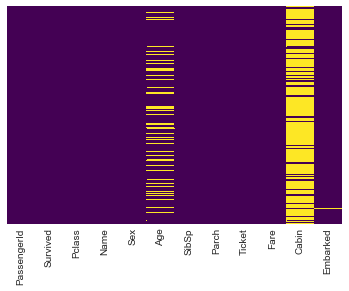

In [7]:
# Visualization for missing data
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

This is a quick, informative way to visualize the incidence of missing observations in our data. Note that, despite how clean this is in our current analysis, when the number of features gets too high, this becomes decidedly less informative. For now, however, we can quickly see that the 'Cabin' feature is going to be essentially useless, and we're going to have to do a bit of work to clean up the 'Age' features (and, to a lesser extent, the 'Embarked' feature). 

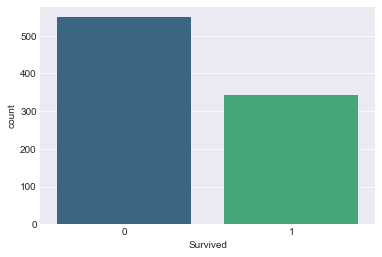

In [8]:
# Visualizing the target variable
sns.countplot('Survived', data=titanic, palette='viridis')
plt.show()

A quick countplot of the target shows that we're working with relatively balanced classes, which means we don't have to address the issues that arise with highly imbalanced classes (i.e. down-sampling, more non-traditional evaluation metrics, etc.).

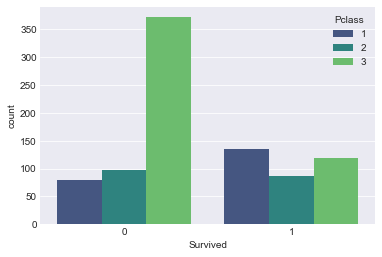

In [9]:
# Survival by class
sns.countplot(x='Survived', hue='Pclass', data=titanic, palette='viridis')
plt.show()

When evaluating our feature variables, we're looking for those that can best separate along our target. Naturally, if we have some target variable in our dataset that can perfectly predict our target, we're essentially done. So, the more separability we can tease out here the better. Looking at the class variable, odds of survival are not good for those in 3rd class. Moreover, it appears odds of survival are somewhat higher for those in 1st class.

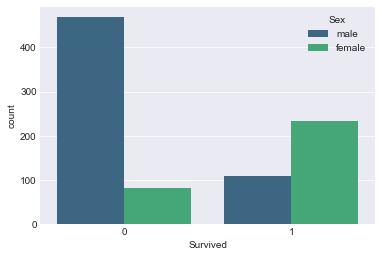

In [10]:
sns.countplot(x='Survived',hue='Sex',data=titanic, palette='viridis')
plt.show()

Here again, there's a fair amount of separability along the 'Sex' variable - females clearly have a much higher chance of surviving than males. This supports narrative accounts of the Titanic disaster that women and children were given priority for lifeboats

### Some simple distributions of the more continuous variables

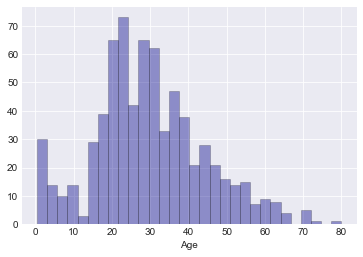

In [11]:
sns.distplot(titanic['Age'].dropna(), bins=30, color='darkblue', kde=False, hist_kws=dict(edgecolor='black', linewidth=0.5))
plt.show()

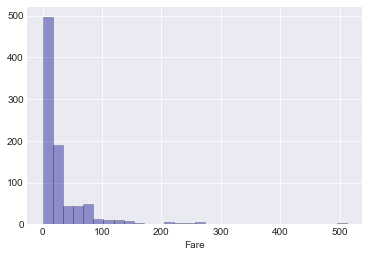

In [12]:
# Possible an outlier at ~500 - may be worth removing
sns.distplot(titanic['Fare'].dropna(), bins=30, color='darkblue', kde=False, hist_kws=dict(edgecolor='black', linewidth=0.5))
plt.show()

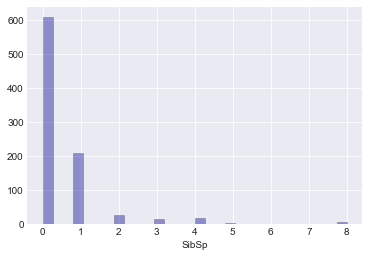

In [13]:
# Clearly an outlier at 8 - may be worth removing
sns.distplot(titanic['SibSp'], bins=30, color='darkblue', kde=False, hist_kws=dict(edgecolor='black', linewidth=0.5))
plt.show()

I'll attend to the outliers mentioned in the previous plots further along in the notebook - some kernels choose to remove these, but I'm inclined to believe they provide additional predictive power.

## 3. Feature engineering/data cleaning

Moving forward, I begin conducting my EDA alongside feature engineering/data cleaning. Visualizing the choices made in feature engineering provides firmer justification for the choices made, and is usually done in the context of how the data look for each of these features. 

Broadly speaking, my feature engineering and data cleaning addresses a few key things manifested in this dataset, some of which was gleaned from trial-and-error, iterating on this analysis several times:

1. In order to ensure we are working with the largest sample possible, and since most of machine-learning models I employ here cannot handle missing values, correct for missing values by imputing values constructed from the underlying feature variable, with the help of information contained in others;
2. Converting the continuous variables (i.e. 'Age', 'Fare', 'SibSp', and 'Parch') into quantile-based, discrete variants. These binned variants perform better than including their more continous counterparts, and make it far easier to visualize the underlying distribution relative to the target 'Survived' variable;
3. Engineering some features based on the raw variables provided - for instance, I construct a title variable from the 'Name' variable, and construct a group size variable based on information contained in the 'Ticket' and parent/sibling variables.

In [14]:
# Begin by encoding the 'Pclass' feature as a set of binaries
class_dummies = pd.get_dummies(all_data['Pclass'])
class_dummies.columns = ['First', 'Second', 'Third']

### 3a. Cleaning missing 'Age' values

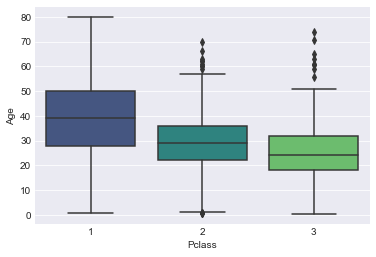

In [15]:
sns.boxplot(x='Pclass', y='Age', data=all_data ,palette='viridis')
plt.show()

In order to capture the full sample, the missing values we noted in 'Age' from the EDA above will have to be dealt with. One could simply impute the mean or median value of the age variable, but the 'Class' variable allows us to do this more carefully. In the boxplot above, note that the mean age differs by class - older individuals are more common in 1st class, while the average age of those in the 3rd class is relatively lower. As such, I'm imputing the mean age, by class, for the missing 'Age' values, especially since the Pclass variable is fully populated

In [16]:
# Replace NaN age values with the mean values within each class
age_by_Pclass = all_data.groupby('Pclass').median()['Age']
all_data['Age'] = np.where((all_data['Age'].isnull()) & (all_data['Pclass'] == 1), age_by_Pclass.iloc[0],
                  np.where((all_data['Age'].isnull()) & (all_data['Pclass'] == 2), age_by_Pclass.iloc[1],
                  np.where((all_data['Age'].isnull()) & (all_data['Pclass'] == 3), age_by_Pclass.iloc[2],
                            all_data['Age'])))


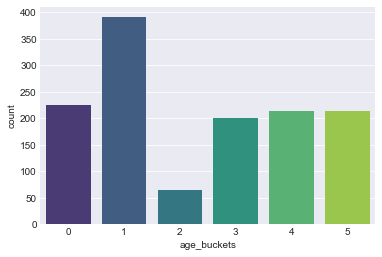

In [17]:
from sklearn.preprocessing import LabelEncoder

# Create age buckets
all_data['age_buckets'] = pd.qcut(all_data['Age'], 6)

label = LabelEncoder()
all_data['age_buckets'] = label.fit_transform(all_data['age_buckets'])

sns.countplot(all_data['age_buckets'], palette='viridis')
plt.show()

Working through this analysis, I found that most of the continuous variables (notably: age, fare, and parents/siblings) perform better when fitting the data when they are binned. After imputing the missing values, I cut the age variable into six buckets.

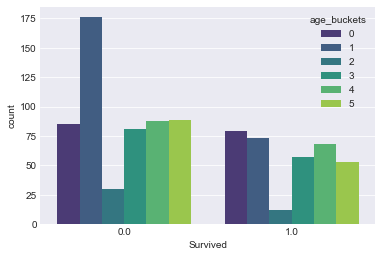

In [18]:
sns.countplot(x='Survived', hue='age_buckets', data=all_data, palette='viridis')
plt.show()

Here, again, we expect additional predictive power from the binned 'Age' feature - in particular, those in the second age bucket have very low odds of survival

### 3b. Create 'Embarked'/'Sex' binaries

In [19]:
# Create dummy variables for 'Sex'
binary_sex = pd.get_dummies(all_data['Sex'])

# Create dummy variables for 'Embarked' - impute 'S' since this is the most common occurence
all_data['Embarked'][all_data['Embarked'].isnull()] = 'S'
binary_embark = pd.get_dummies(all_data['Embarked'])

C:\Users\Jared\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Recall that there were two missing values in the 'Embarked' variable. Since the incidence of missing values is so little, more exhaustive imputation is likely unnecessary. Here, I populate the missing values with the most common 'Embarked' class.

### 3c. Create 'Title' feature based on 'Name' variable and corresponding binaries

In [20]:
len(all_data.Name.unique())

1307

In [21]:
all_data.Name.unique()[1:5]

array(['Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

The 'Name' variable requires a bit more engineering to be a useful predictive features. At present, it represents something of an individual fixed-effect (there's my econometrics training creeping in) that uniquely identifies each individual with their own name and title. However, we observe that there is a common structure in the way these names are entered in the dataset. As such, I extract the title portion of these names for use in my model.

In [22]:
# Create a 'titles' variable based on names that occur in both train and test
all_titles = all_data.Name.str.extract('(?P<Title>(?<=, ).*?(?=\.))', expand=True)

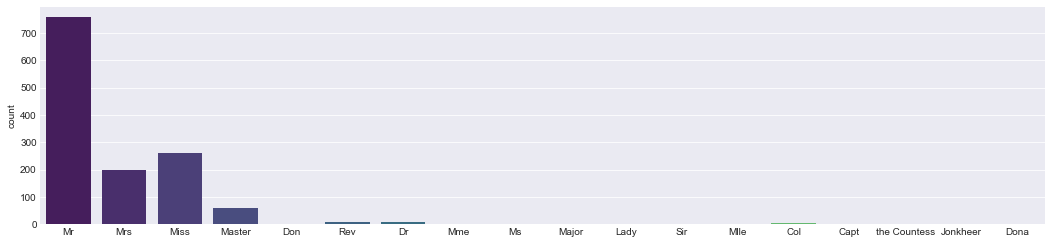

In [23]:
# Visualize the occur of these titles and the quantity
plt.figure(figsize=(18,4))
sns.countplot(x=all_titles['Title'].tolist(), palette='viridis')
plt.show()

By extracting these titles, we whittle down the number of unique names (1,307) to 17 unique titles, which can be furthered honed by grouping synonymous titles into fewer buckets.

In [24]:
# Map titles to create groups, lumping the obscure titles into a single bucket
title_map = {'Mr':'Mr', 'Mrs':'Mrs', 'Mme':'Mrs', 'Miss':'Ms', 'Ms':'Ms', 'Mlle':'Ms', 
             'Master':'Spec', 'Rev':'Spec', 'Dr':'Spec',
             'Don':'Rare', 'Major':'Rare', 'Lady':'Rare', 'Sir':'Rare', 'Col':'Rare', 'Capt':'Rare', 'the Countess':'Rare',
             'Jonkheer':'Rare', 'Dona':'Rare'}
all_data['title_buckets'] = all_titles['Title'].map(title_map)

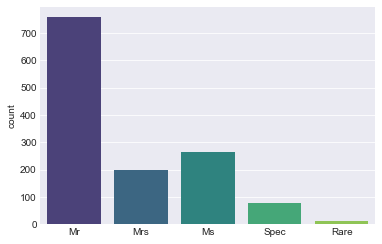

In [25]:
sns.countplot(x=all_data['title_buckets'].tolist(), palette='viridis')
plt.show()

I've opted for five unique title buckets in my analysis. 'Mr', 'Mrs', and 'Ms,' are fairly standard choices. The remaining titles, however, I break out into two different buckets - 'Rare' and 'Spec,' or special. In the special category, I've included those individuals who are doctors, reverends, and masters. The remaining titles, which have far fewer observations, are lumped into the 'Rare' bucket. The distribution of these categories, relative to the target, are displayed below. We observe a similar phenomenon related to the 'Sex' feature here.

In [26]:
title_dummies = pd.get_dummies(all_data['title_buckets'])

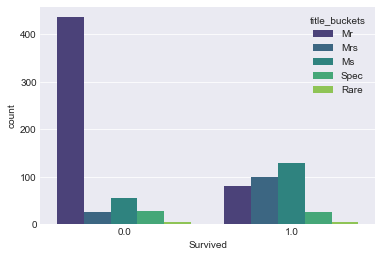

In [27]:
# Visualize these relative to survival
sns.countplot(x='Survived', hue='title_buckets', data=all_data, palette='viridis')
plt.show()

### 3d. Create a fare buckets feature

I chose to treat the 'fare' feature in much the same way as the 'Age' feature - I attended to missing variables by using median fares by class (it makes sense that the average fare would be much higher for the higher classes) and bucket this accordingly.

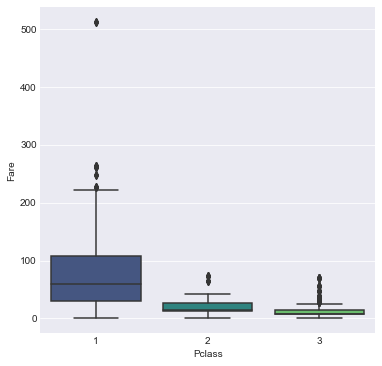

In [28]:
# Visualize class versus fare
plt.figure(figsize=(6,6))
sns.boxplot(x='Pclass', y='Fare', data=all_data ,palette='viridis')
plt.show()

In [29]:
fare_by_Pclass = all_data.groupby('Pclass').median()['Fare']


all_data['Fare'] = np.where((all_data['Fare'].isnull()) & (all_data['Pclass'] == 1), fare_by_Pclass.iloc[0],
              np.where((all_data['Fare'].isnull()) & (all_data['Pclass'] == 2), fare_by_Pclass.iloc[1],
              np.where((all_data['Fare'].isnull()) & (all_data['Pclass'] == 3), fare_by_Pclass.iloc[2],
              all_data['Fare'])))

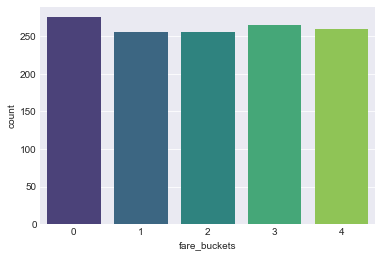

In [30]:
# Create fare buckets
all_data['fare_buckets'] = pd.qcut(all_data['Fare'], 5)

label = LabelEncoder()
all_data['fare_buckets'] = label.fit_transform(all_data['fare_buckets'])

sns.countplot(all_data['fare_buckets'], palette='viridis')
plt.show()

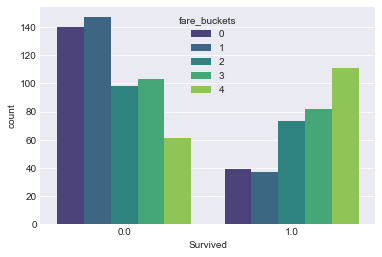

In [31]:
# Having paid a high fare clearly has value
sns.countplot(x='Survived', hue='fare_buckets', data=all_data, palette='viridis')
plt.show()

Using these five quantile buckets, we can plainly see that those in the highest fare bucket faired (no pun intended) better than their lower-fare counterparts, which corresponds nicely with what we found in the class variable. 

### 3e. Create a 'family size' feature and bin accordingly

You'll notice a trend here- that is converting the continous variables into discretized variants. I chose to combine the 'SibSp' (the number of siblings/spouses on board) and 'Parch' (the number of parents and children on board) into a single 'Family Size' variable reflecting the entire size of a family on board, and adding one for the individual to whom these features are with respect to

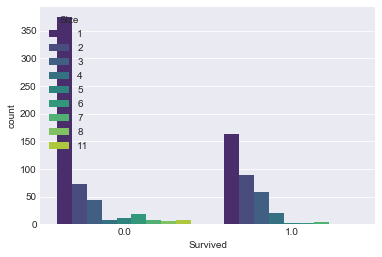

In [32]:
# Parents and children plus siblings/spouses - large families do not fare very well
all_data['Size'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['Alone'] = np.where(all_data['Size'] == 1, 1, 0)
sns.countplot(x='Survived', hue='Size', data=all_data, palette='viridis')
plt.show()

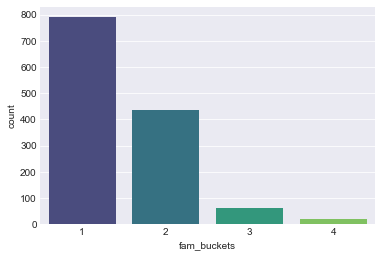

In [33]:
# Create Size buckets
all_data['fam_buckets'] = np.where(all_data['Size'] == 1, 1,
              ##np.where(all_data['Size'] == 2, 2, 
              np.where((all_data['Size'] >= 2) & (all_data['Size'] <= 4),2, 
              np.where((all_data['Size'] >= 5) & (all_data['Size'] < 8),3,4)))

sns.countplot(all_data['fam_buckets'], palette='viridis')
plt.show()

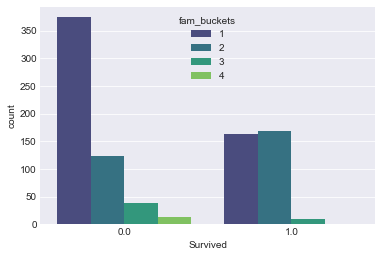

In [34]:
# Large families are separable - big families don't make it, or very rarely make it, and your chances are better in the 2-4 range
sns.countplot(x='Survived', hue='fam_buckets', data=all_data, palette='viridis')
plt.show()

Per my mention of *not* removing some of the outliers above, there's a fairly clear distinction in the survival rate by family size. Simply put- larger families survive at a much lower rate. Moreover, *very* large families simply do not survive in our training dataset.

### 3f. Identify family/friend groups

Pursuing this vein of feature engineering was insipired by this [kernel](https://www.kaggle.com/pliptor/divide-and-conquer-0-82296). While I did not go to the same lengths to develop this feature as in the linked notebook above, I did choose to examine to what extent these groups could be identified in a relatively simpler way, and developed a groups feature that could be bucketed much like the other continuous features established herein.

In [35]:
# Extract last names
all_data['fam_name'] = all_data.Name.str.extract('(?P<Title>.*?(?=,))', expand=False)
print('Number of unique surnames in sample: {}'.format(len(all_data['fam_name'].unique())))
print('Number of unique tickets in sample: {}'.format(len(all_data['Ticket'].unique())))

Number of unique surnames in sample: 875
Number of unique tickets in sample: 929


In [36]:
# It's fair to assume most of the variation in last names is captured above in the fam_buckets variable, but 
# tickets might capture those that booked together who are not necessarily related
all_data['Ticket'].value_counts()[0:10]

CA. 2343        11
1601             8
CA 2144          8
347077           7
347082           7
3101295          7
S.O.C. 14879     7
PC 17608         7
347088           6
382652           6
Name: Ticket, dtype: int64

In [37]:
# Case and point: This group below is considered 'Alone' but clearly booked together as a group
all_data[all_data['Ticket'] == '1601']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,age_buckets,title_buckets,fare_buckets,Size,Alone,fam_buckets,fam_name
74,32.0,NaN,S,56.4958,"Bing, Mr. Lee",0,75,3,male,0,1.0,1601,3,Mr,4,1,1,1,Bing
169,28.0,NaN,S,56.4958,"Ling, Mr. Lee",0,170,3,male,0,0.0,1601,3,Mr,4,1,1,1,Ling
509,26.0,NaN,S,56.4958,"Lang, Mr. Fang",0,510,3,male,0,1.0,1601,2,Mr,4,1,1,1,Lang
643,24.0,NaN,S,56.4958,"Foo, Mr. Choong",0,644,3,male,0,1.0,1601,1,Mr,4,1,1,1,Foo
692,24.0,NaN,S,56.4958,"Lam, Mr. Ali",0,693,3,male,0,1.0,1601,1,Mr,4,1,1,1,Lam
826,24.0,NaN,S,56.4958,"Lam, Mr. Len",0,827,3,male,0,0.0,1601,1,Mr,4,1,1,1,Lam
838,32.0,NaN,S,56.4958,"Chip, Mr. Chang",0,839,3,male,0,1.0,1601,3,Mr,4,1,1,1,Chip
39,24.0,NaN,S,56.4958,"Hee, Mr. Ling",0,931,3,male,0,NaN,1601,1,Mr,4,1,1,1,Hee


In [38]:
tickets = pd.DataFrame(all_data['Ticket'].value_counts())
tickets.reset_index(inplace=True)
tickets.columns = ['Ticket', 'Group_size']
ticket_map = dict(zip(tickets['Ticket'].tolist(), tickets['Group_size'].tolist()))

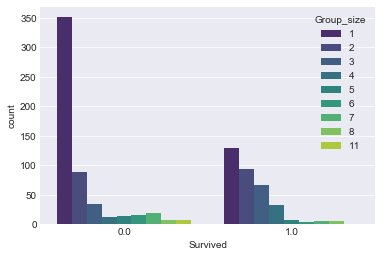

In [39]:
all_data['Group_size'] = all_data['Ticket'].map(ticket_map)
sns.countplot(x='Survived', hue='Group_size', data=all_data, palette='viridis')
plt.show()

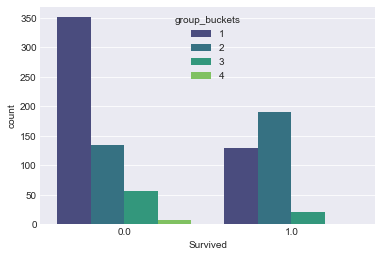

In [40]:
# Create Group_size buckets
all_data['group_buckets'] = np.where(all_data['Group_size'] == 1, 1,
              ##np.where(all_data['Group_size'] == 2, 2, 
              np.where((all_data['Group_size'] >= 2) & (all_data['Group_size'] <= 4),2, 
              np.where((all_data['Group_size'] >= 5) & (all_data['Group_size'] <= 8),3,4)))

sns.countplot(x='Survived', hue='group_buckets', data=all_data, palette='viridis')
plt.show()

### 3g. Examine 'Cabin' Feature

I still contend that the 'Cabin' feature is largely useless in this analysis, but a number of kernels have attempted to glean predictive power from it. The simplest way to do so is divide the feature into those assigned a cabin, and those not.

C:\Users\Jared\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


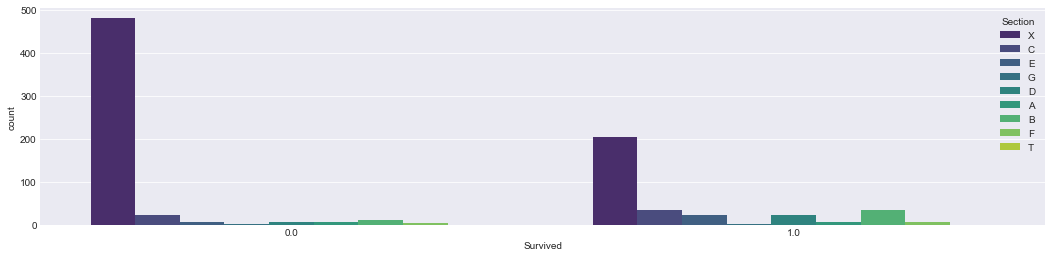

In [41]:
# Recode missings and examine distribution
all_data['Cabin'][all_data['Cabin'].isnull()] = 'X'
all_data['Section'] = all_data.Cabin.str.extract('(?P<Section>([A-z]))', expand=True)['Section']

plt.figure(figsize=(18,4))
sns.countplot(x='Survived', hue='Section', data=all_data, palette='viridis')
plt.show()

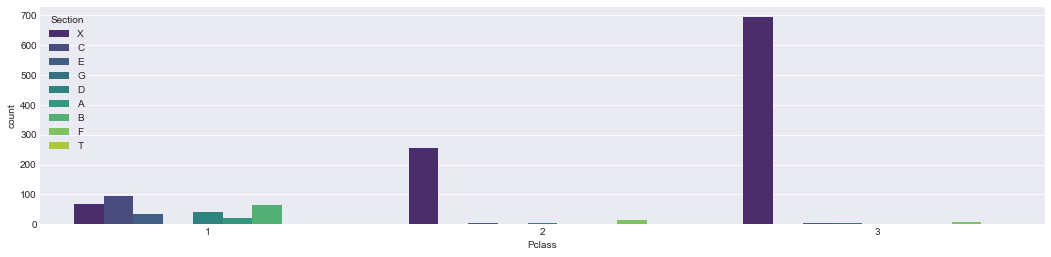

In [42]:
plt.figure(figsize=(18,4))
sns.countplot(x='Pclass', hue='Section', data=all_data, palette='viridis')
plt.show()

In [43]:
section_binaries = pd.get_dummies(all_data['Section'])

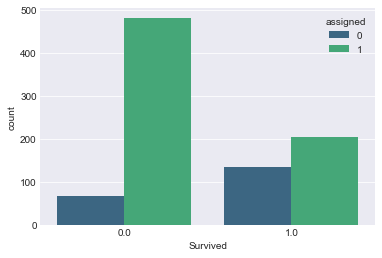

In [44]:
all_data['assigned'] = np.where(all_data['Cabin'] == 'X', 1, 0)
sns.countplot(x='Survived', hue='assigned', data=all_data, palette='viridis')
plt.show()

## 4. Assemble final dataset prior to training

Doggedly pursuing higher public scores on the Kaggle leaderboard, led to *many* iterations of the above features, and led to the development of much of the cleaning and engineering detailed above. In the end, I was able to achieve the highest Cross-Validation scores, and highest public scores on the Kaggle website, with a subset of the features described and engineered above. To some extent, this was also determined through my iterations looking a feature importance plots.

I used the bucketed 'Fare', 'Family', and 'Age', binary 'Sex' variables, constructed 'Title' feature, and dummy variables built on the 'Class' feature. The 'Embarked' and 'Section' binaries did not improve predictive accuracy. Additionally, despite all the work put into the creation of the 'group_buckets' variable based on groups of individuals purchasing tickets together, I did not find it reliably improved predictive accuracy, with the exception of the LightGBM model, which is why I've left it in here.

In [45]:
# Select features for training
feats = pd.concat([all_data[['fare_buckets', 'fam_buckets', 'age_buckets', 'group_buckets']],
              binary_sex,
              title_dummies,
              ## section_binaries,
              ## binary_embark,
              class_dummies
              ], axis=1)

feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
fare_buckets     1309 non-null int64
fam_buckets      1309 non-null int32
age_buckets      1309 non-null int64
group_buckets    1309 non-null int32
female           1309 non-null uint8
male             1309 non-null uint8
Mr               1309 non-null uint8
Mrs              1309 non-null uint8
Ms               1309 non-null uint8
Rare             1309 non-null uint8
Spec             1309 non-null uint8
First            1309 non-null uint8
Second           1309 non-null uint8
Third            1309 non-null uint8
dtypes: int32(2), int64(2), uint8(10)
memory usage: 93.7 KB


In [46]:
# Since some feature engineering and variable imputation had to be done with respect to the full population, I split the data
X_ = feats[:t_obs]
test_ = feats[t_obs:]
y = titanic['Survived']

In [47]:
# Scale features prior to estimation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_)
X = pd.DataFrame(X_scaled)
X.columns  = X_.columns

Since I intend to use a wide range of models to assess their predictive power with this selection of features for training, it's good practice to scale all the variables in thte dataset. I rely on the sklearn StandardScalar to perform this scaling.

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
fare_buckets     891 non-null float64
fam_buckets      891 non-null float64
age_buckets      891 non-null float64
group_buckets    891 non-null float64
female           891 non-null float64
male             891 non-null float64
Mr               891 non-null float64
Mrs              891 non-null float64
Ms               891 non-null float64
Rare             891 non-null float64
Spec             891 non-null float64
First            891 non-null float64
Second           891 non-null float64
Third            891 non-null float64
dtypes: float64(14)
memory usage: 97.5 KB


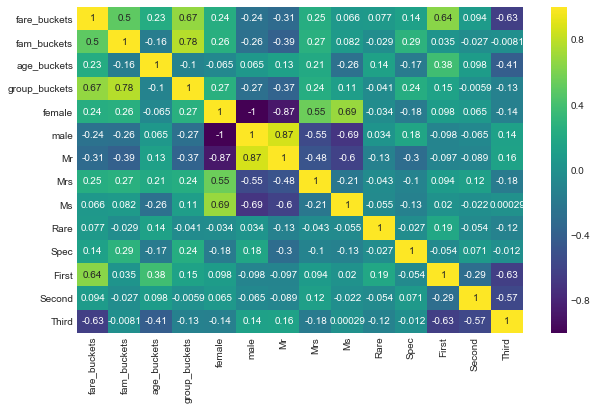

In [49]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), cmap='viridis', annot=True)
plt.show()

## 5. Modelling

It's well established that there is no one perfect algorithm for every machine learning problem. With the sklearn library, it's trivial to test a the predictive accuracy of a number of models. In this analysis, I assess the performance of the following 8 classifiers:
1. K-Nearest Neighbors
2. Logistic Regression
3. Decision Tree
4. Support Vector Machine
5. Random Forest
6. AdaBoost
7. ExtraTrees
8. Gradient-Boosting Machine

kNN and Logistic Regression are fairly standard baseline models to assess how well our model is doing absent more complex methods, while the latter four are a mix of ensemble models which are regularly referenced in other kernels assessing this dataset

In [50]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
model_performance = {}

### 5a. kNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

_ = cross_validate(knn, X_train, y_train,cv=5)['test_score']
model_performance['k-Nearest Neighbors'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[153  16]
 [ 40  86]]
             precision    recall  f1-score   support

          0       0.79      0.91      0.85       169
          1       0.84      0.68      0.75       126

avg / total       0.81      0.81      0.81       295



### 5b. Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

_ = cross_validate(lr, X_train, y_train,cv=5)['test_score']
model_performance['Logistic Regression'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[155  14]
 [ 40  86]]
             precision    recall  f1-score   support

          0       0.79      0.92      0.85       169
          1       0.86      0.68      0.76       126

avg / total       0.82      0.82      0.81       295



### 5c. Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

_ = cross_validate(dtc, X_train, y_train,cv=5)['test_score']
model_performance['Decision Tree'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[153  16]
 [ 52  74]]
             precision    recall  f1-score   support

          0       0.75      0.91      0.82       169
          1       0.82      0.59      0.69       126

avg / total       0.78      0.77      0.76       295



### 5d. SVM

In [55]:
# Support Vector Machine
from sklearn.svm import SVC
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

_ = cross_validate(svc, X_train, y_train,cv=5)['test_score']
model_performance['Support Vector Machine'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[155  14]
 [ 36  90]]
             precision    recall  f1-score   support

          0       0.81      0.92      0.86       169
          1       0.87      0.71      0.78       126

avg / total       0.83      0.83      0.83       295



### 5e. RandomForest

In [56]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

_ = cross_validate(rfc, X_train, y_train,cv=5)['test_score']
model_performance['Random Forest'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[151  18]
 [ 37  89]]
             precision    recall  f1-score   support

          0       0.80      0.89      0.85       169
          1       0.83      0.71      0.76       126

avg / total       0.82      0.81      0.81       295



### 5f. Adaboost

In [57]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

_ = cross_validate(ada, X_train, y_train,cv=5)['test_score']
model_performance['Adaboost'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[146  23]
 [ 36  90]]
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       169
          1       0.80      0.71      0.75       126

avg / total       0.80      0.80      0.80       295



### 5g. ExtraTrees

In [58]:
# ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier
xtc = ExtraTreesClassifier()

xtc.fit(X_train, y_train)
y_pred = xtc.predict(X_test)

_ = cross_validate(xtc, X_train, y_train,cv=5)['test_score']
model_performance['ExtraTrees'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[152  17]
 [ 45  81]]
             precision    recall  f1-score   support

          0       0.77      0.90      0.83       169
          1       0.83      0.64      0.72       126

avg / total       0.80      0.79      0.78       295



### 5h. Gradient-Boosted Decision Tree

In [59]:
# Gradient-Boosted Decision Tree
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

_ = cross_validate(gbc, X_train, y_train,cv=5)['test_score']
model_performance['Gradient-Boosting Classifier'] = np.array(_).mean()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[150  19]
 [ 33  93]]
             precision    recall  f1-score   support

          0       0.82      0.89      0.85       169
          1       0.83      0.74      0.78       126

avg / total       0.82      0.82      0.82       295



### 5i. Variable Importance and Comparison of Mean Accuracy

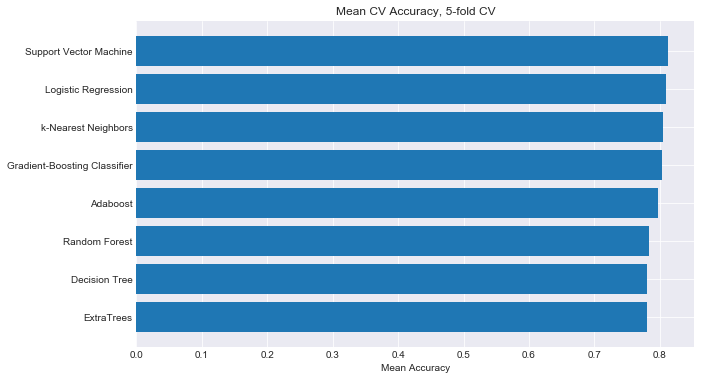

In [60]:
_ = sorted([x for x in model_performance.items()], key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(np.arange(len(_)), [x[1] for x in _])

ax.set_yticks(np.arange(len(_)))
ax.set_yticklabels([x[0] for x in _])
ax.set_xlabel('Mean Accuracy')
ax.set_title('Mean CV Accuracy, 5-fold CV')

plt.show()

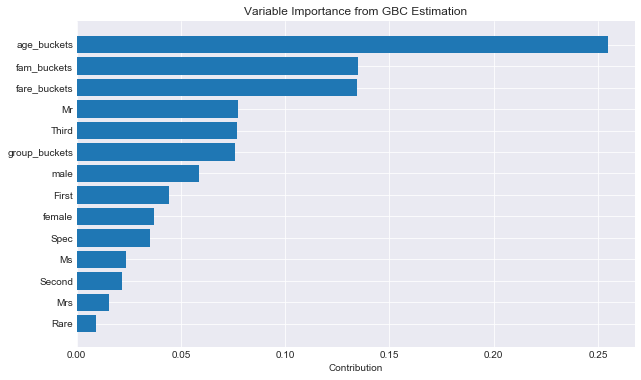

In [61]:
_ = sorted(list(zip(X_train.columns.tolist(), gbc.feature_importances_.tolist())), key=lambda x:x[1])

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(np.arange(len(_)), [x[1] for x in _])

ax.set_yticks(np.arange(len(_)))
ax.set_yticklabels([x[0] for x in _])
ax.set_xlabel('Contribution')
ax.set_title('Variable Importance from GBC Estimation')

plt.show()

## 6. Parameter Tuning and Model Selection

In [62]:
from sklearn.model_selection import GridSearchCV

# Tune the gbm
grid_values = {'n_estimators': [10, 100, 1000],
               'learning_rate': [0.001, 0.01, 0.1],
               'max_depth': [1,2,3],
               'max_features': ['sqrt', 'log2']}

gbc_grid = GridSearchCV(gbc, param_grid = grid_values)
gbc_grid.fit(X, y)
print(gbc_grid.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1000}


In [63]:
svc = SVC()

# Tune the SVM
grid_values = {'C':[1,10,20,30,40,50,60,70,80,90,100],
               'gamma':[0.01],
               'kernel': ['rbf', 'poly']}

svc_grid = GridSearchCV(svc, param_grid = grid_values)
svc_grid.fit(X,y)
print(svc_grid.best_params_)

{'C': 30, 'gamma': 0.01, 'kernel': 'rbf'}


In [64]:
rfc = RandomForestClassifier()

# Tune the RandomForest
grid_values = {'max_depth':[3,4,5,6,7,8,9,10,11,12],
               'max_features':['log2', 'sqrt'],
               'n_estimators':[3,4,5,6,7,8,9,10,11,12],
               'min_samples_split':[2,3,4]
               }

rfc_grid = GridSearchCV(rfc, param_grid = grid_values)
rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_)

{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 5}


## 7. Fit final model on test data and report predictions

While it seems the simple Logistic Regression performs the best in terms of CV Mean Accuracy (per the plot above), I'm inclined to use the Gradient Boosting Machine (which performs second per the same metric) because its hyper-parameters can be more finely tuned. As such, using the tuned hyperparameters established in the grid search above, I conduct a final run of the Gradient Boosting Machine to generate final predictions for submission

In [66]:
# Scale features prior to estimation
test_scaled = scaler.fit_transform(test_)
test_feats = pd.DataFrame(test_scaled)

In [67]:
# Create more usefully named variants of existing feature Dataframes
features = X
labels = y
test_features = test_feats

In [68]:
# Fit final model
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features='log2', n_estimators=1000)
clf.fit(X,y)
y_pred = clf.predict(test_feats)

In [69]:
# Prepare data for evaluation
final_predictions = pd.DataFrame.from_dict(dict(zip(test['PassengerId'], y_pred)), orient='index')
final_predictions.reset_index(inplace=True)
final_predictions.columns = ['PassengerId', 'Survived']

final_predictions.to_csv('survivor_predictions.csv',index=False)

## 8. LightGBM

When I began working on this notebook, I was fully aware of the LightGBM model and the degree to which it (along with XGBoost) was being employed in winning kernels, but found working with it to be a bit more difficult. After working for some time on the Home Credit Default Risk competition, I stumbled across and immensely helpful [kernel](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) for getting this up and running. While I spent less time with hyperparameter tuning in this one, I found that once I got things up and running it immediately improved the scores I was generating both on my cross-validation sets and for my submissions to the competition. This landed my kernel within the top 15%

In [70]:
# Convert to NumPy arrays - store feature names
feature_names = features.columns.tolist()
features = np.array(features)
test_features = np.array(test_features)

In [71]:
from sklearn.model_selection import KFold

# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 101)

In [72]:
# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))
    
# Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])
    
# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])
    
# Lists for recording validation and training scores
valid_scores = []
train_scores = []

In [73]:
import lightgbm as lgb 

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):
        
    # Training data for the fold
    train_features, train_labels = features[train_indices], labels[train_indices]
    #Validation data for the fold
    valid_features, valid_labels = features[valid_indices], labels[valid_indices]
    
    # Create the bst
    bst = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                            class_weight = 'balanced', learning_rate = 0.05, 
                            reg_alpha = 0.1, reg_lambda = 0.1, 
                            subsample = 0.8, random_state = 101)
        
    # Train the bst
    bst.fit(train_features, train_labels, eval_metric = 'auc',
            eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
            eval_names = ['valid', 'train'],
            early_stopping_rounds = 100, verbose = 200)
    
    # Record the best iteration
    best_iteration = bst.best_iteration_
        
    # Record the feature importances
    feature_importance_values += bst.feature_importances_ / k_fold.n_splits
        
    # Make predictions
    test_predictions += bst.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
    # Record the out of fold predictions
    out_of_fold[valid_indices] = bst.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
    # Record the best score
    valid_score = bst.best_score_['valid']['auc']
    train_score = bst.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score) 

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.894381	train's auc: 0.93134
Early stopping, best iteration is:
[208]	valid's auc: 0.897033	train's auc: 0.931883
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[34]	valid's auc: 0.897553	train's auc: 0.901965
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid's auc: 0.882068	train's auc: 0.923354
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid's auc: 0.870344	train's auc: 0.916331
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid's auc: 0.880214	train's auc: 0.918925


In [74]:
# Prepare data for evaluation
final_predictions = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test_predictions})
final_predictions['Survived'] = np.where(final_predictions['Survived'] > 0.7, 1, 0)

In [75]:
final_predictions.to_csv('survivor_predictions.csv',index=False)

## 9. Credits

I find it hard to believe any auto-didact can really get started in this field in a vacuum. I looked through a LOT of kernels, including the one linked above, and owe a lot of credit to [Jose Portilla's bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/learn/v4/) on Udemy for developing my thinking about the structure and first steps to get this off the ground. While this isn't necessarily an endorsement, I found the course to be very helpful in getting a gist of the general workflow for these data science projects.